In [51]:
from numpy import array, exp 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import openturns as ot
from scipy.optimize import curve_fit 
from scipy.stats import genhyperbolic
from scipy.stats import levy_stable
from scipy.stats import norm
from scipy.stats import cumfreq
from scipy.stats import kstest
from scipy.stats import ks_2samp
from scipy.stats import cramervonmises_2samp
from scipy.stats import anderson_ksamp

dataset = pd.read_csv("../data/log_return_data.csv")
dataset

,log_return_vkco,log_return_tcs_il,log_return_poly_il,log_return_five_il
0,-0.012110,-0.004162,-0.003712,-0.013377
1,-0.035292,0.000000,-0.029352,-0.024070
2,0.011583,0.002083,-0.013279,0.007894
3,-0.006740,0.004154,0.025964,-0.002916
4,-0.009709,0.015425,-0.010984,-0.007034
...,...,...,...,...
248,-0.007648,0.018653,0.030041,0.010193
249,0.019012,0.044184,0.029452,-0.006216
250,0.018657,0.038540,0.008584,0.036732
251,0.046940,0.035287,0.042393,0.000000


In [52]:
#Делим интервал значений случ. вел на bins подинтервалов. Вычисляем количество попаданий в эти подинтервалы
#Фактически имитируем набор данных для plot.hist()
def get_intervals(dataframe, column, bins):
    intervals = []
    data = dataframe[column]
    ln = len(data)
    max_value = max(data)
    min_value = min(data)
    interval_length = (max_value - min_value)
    for i in range(0, bins):
        s = 0
        a = min_value + (i)*interval_length/bins
        b = min_value + (i+1)*interval_length/bins
        for k in range(0, len(data)):
            if (data[k]>= a and data[k]<b):
                s = s + 1
        #intervals.append(s/(ln-1))
        intervals.append(s)
    x_interavals = np.arange(min_value, max_value, abs(max_value- min_value)/bins)
    return intervals, x_interavals, min_value, max_value


In [53]:
def get_rvs_intervals(data, bins, x_data):
    intervals = []
    max_value = max(x_data)
    min_value = min(x_data)
    interval_length = (max_value - min_value)
    for i in range(0, bins):
        s = 0
        a = min_value + (i)*interval_length/bins
        b = min_value + (i+1)*interval_length/bins
        for k in range(0, len(data)):
            if (data[k]>= a and data[k]<b):
                s = s + 1
        intervals.append(s)
    norm_intervals = [x/sum(intervals) for x in intervals]
    return norm_intervals

In [54]:
#Определяем приближающую функцию - Нормальное распределение
def norm_mapping(values_x, a, b): 
    #return 1/(math.sqrt(2*math.pi)*b) * exp(-1/2*((values_x-a)/b)**2)
    return norm.pdf(values_x,a,b)
    

In [55]:
#Определяем приближающую функцию - Гиперболическое распределение
def hyper_mapping(values_x, p, a, b, mu, delta):
    #genhyperbolic.pdf(x, p, a, b, loc, scale)  scale = delta, loc = mu, p = lambda, a = alpha delta, b = beta delta
    if (a>b):
        return genhyperbolic.pdf(values_x, p, a, b, mu, delta)
    else:
        return 0

In [56]:
#Определяем приближающую функцию - Устойчивое распределение
def stable_mapping(values_x, alpha, beta, gamma, mu):
    return levy_stable.pdf(values_x, alpha, beta, gamma, mu)

In [57]:
#Определяем приближающую функцию - Устойчивое распределение
def stable_mapping(values_x, alpha, beta, gamma, mu):
    return levy_stable.pdf(values_x, alpha, beta, gamma, mu)


In [58]:
def test(x, a, b, c, d, e, f):
    return a+b*x+c*x**2+d*x**3+e*x**4+f*x**5


In [59]:
#Читаем файл с данными
dataset = pd.read_csv("../data/log_return_data.csv")

#Выполняем обработку исходных данных
bins = 25
compName = 'log_return_five_il' #'log_return_five_il' log_return_vkco	log_return_tcs_il	log_return_poly_il gazpr_futures
print(compName)
readData = get_intervals(dataset, compName, bins)  
y_data, x_data, min_value, max_value = readData[0], readData[1], readData[2], readData[3]
x_fit = np.arange(min_value, max_value, abs(max_value- min_value)/400)
y_data1 = [x/sum(y_data) for x in y_data]

#Строим эмпирическую функцию распределения
emp_data = cumfreq(dataset[compName], numbins=bins, defaultreallimits=None, weights=None)


log_return_five_il


In [60]:
def get_emp_data(dataframe, columns, bins):
    #Выполняем обработку исходных данных
    readData = get_intervals(dataset, columns, bins)  
    y_data, x_data, min_value, max_value = readData[0], readData[1], readData[2], readData[3]
    x_fit = np.arange(min_value, max_value, abs(max_value- min_value)/400)
    y_data1 = [x/sum(y_data) for x in y_data]

    #Строим эмпирическую функцию распределения
    emp_data = cumfreq(dataset[columns], numbins=bins, defaultreallimits=None, weights=None)
    return emp_data, y_data1, x_fit, x_data, y_data


In [77]:
def closer_finding_functions_hyperbolic(x_data, y_data, data, column):
    #Производим приближение - Гиперболическое распределение
    params, _  = curve_fit(hyper_mapping, x_data, y_data) 
    p, a, b, mu, delta = params[0], params[1], params[2], params[3], params[4]
    y_fit = genhyperbolic.pdf(x_fit, p, a, b, mu, delta) 
    
    #Считаем pvalue - Гиперболическое распределение
    r = genhyperbolic.rvs(p, a, b, mu, delta, size=253, random_state=None)
    #Выполняем нормировку набора случайных величин
    norm_rvs_data = get_rvs_intervals(r, bins, x_data)
    norm_rvs_data1 = [x/sum(norm_rvs_data) for x in norm_rvs_data]

    return params, r, y_fit, norm_rvs_data

In [80]:
#Производим приближение - Устойчивое распределение
def closer_finding_functions_stable(x_data, data, columns):
    params = levy_stable._fitstart(data[columns])
    alpha, beta , gamma, mu = params[0], params[1], params[2], params[3]

    y_fit = levy_stable.pdf(x_fit, alpha, beta, gamma, mu)

    #Считаем pvalue - Устойчивое распределение
    r = levy_stable.rvs(alpha, beta, gamma, mu, size=253, random_state=None)

    #Выполняем нормировку набора случайных величин
    norm_rvs_data = get_rvs_intervals(r, bins, x_data)
    return params, r, y_fit, norm_rvs_data

In [81]:
# #Производим приближение - Распределение Мейснера
def closer_finding_functions_meixner(x_data, data, columns):
    data1 = [[i] for i in data[columns]]
    sample = ot.Sample(data1)
    ot.ResourceMap.SetAsUnsignedInteger('DistributionFactory-DefaultBootstrapSize', 253)
    fittedRes = ot.MeixnerDistributionFactory().build(sample)
    params = fittedRes.getParameter()
    alpha, beta , gamma, delta = params[0], params[1], params[2], params[3]
    distribution = ot.MeixnerDistribution(alpha, beta , gamma, delta)
    y_fit = []
    for x in x_fit:
        y_fit.append(distribution.computePDF(x))
    
    sample = ot.MeixnerDistribution(alpha, beta, gamma, delta).getSample(253)
    r = sample.asPoint()
    norm_rvs_data = get_rvs_intervals(r, bins, x_data)

    return params, sample, y_fit, norm_rvs_data

### Гиперболическое распределение

In [82]:
p_value_hyperbolic_kstest = []
p_value_hyperbolic_cramervonmises = []
p_value_hyperbolic_anderson = []
df_hyperbolic_distribution = pd.DataFrame()

for column in dataset.columns:
    emp_data, y_data1, x_fit, x_data, y_data = get_emp_data(dataset, column, 15)
    params_hyperbolic, hyperbolic_distribution, y_fit_hyperbolic, norm_rvs_hyperbolic = closer_finding_functions_hyperbolic(x_data, y_data, dataset, column) 
    p, a, b, mu, delta = params_hyperbolic[0], params_hyperbolic[1], params_hyperbolic[2], params_hyperbolic[3], params_hyperbolic[4]
    p_value_hyperbolic_kstest.append(ks_2samp(dataset[column], hyperbolic_distribution, alternative='two-sided', method='auto')[1])
    p_value_hyperbolic_cramervonmises.append(cramervonmises_2samp(dataset[column], hyperbolic_distribution, method='auto').pvalue)
    p_value_hyperbolic_anderson.append(anderson_ksamp([dataset[column], hyperbolic_distribution]).significance_level)

    df_hyperbolic_distribution[column] = hyperbolic_distribution


p_value_hyperbolic = pd.DataFrame(data={'ks_test': p_value_hyperbolic_kstest, 'anderson': p_value_hyperbolic_anderson, 'cramervonmises': p_value_hyperbolic_cramervonmises},
                    index=dataset.columns)



p_value_hyperbolic.to_csv('../p_value/p_value_hyperbolic.csv', index=True)
print(p_value_hyperbolic)
df_hyperbolic_distribution

/tmp/ipykernel_4607/1226410589.py:12: UserWarning: p-value floored: true value smaller than 0.001
  p_value_hyperbolic_anderson.append(anderson_ksamp([dataset[column], hyperbolic_distribution]).significance_level)
/tmp/ipykernel_4607/1226410589.py:12: UserWarning: p-value floored: true value smaller than 0.001
  p_value_hyperbolic_anderson.append(anderson_ksamp([dataset[column], hyperbolic_distribution]).significance_level)


                         ks_test  anderson  cramervonmises
log_return_vkco     7.152951e-29     0.001    8.085265e-10
log_return_tcs_il   8.598872e-48     0.001    4.767974e-10
log_return_poly_il  1.299392e-41     0.001    3.309044e-09
log_return_five_il  7.705370e-54     0.001    3.842439e-09


/tmp/ipykernel_4607/1226410589.py:12: UserWarning: p-value floored: true value smaller than 0.001
  p_value_hyperbolic_anderson.append(anderson_ksamp([dataset[column], hyperbolic_distribution]).significance_level)
/tmp/ipykernel_4607/1226410589.py:12: UserWarning: p-value floored: true value smaller than 0.001
  p_value_hyperbolic_anderson.append(anderson_ksamp([dataset[column], hyperbolic_distribution]).significance_level)


,log_return_vkco,log_return_tcs_il,log_return_poly_il,log_return_five_il
0,-0.005669,-0.009762,-0.013691,-0.016911
1,-0.007208,-0.012927,-0.015875,-0.013423
2,-0.010338,-0.011578,-0.014909,-0.009678
3,-0.001932,-0.011107,-0.013573,-0.025430
4,-0.003219,-0.016649,-0.010174,-0.008769
...,...,...,...,...
248,-0.009291,-0.015330,-0.012604,-0.021654
249,-0.018852,-0.008613,-0.018798,-0.019011
250,-0.014152,-0.009477,-0.007508,-0.012015
251,-0.022128,-0.000999,-0.010230,-0.012214


### Stable распределение

In [83]:
p_value_stable_kstest = []
p_value_stable_cramervonmises = []
p_value_stable_anderson = []
df_stable_distribution = pd.DataFrame()

for column in dataset.columns:
    params_stable, stable_distribution, y_fit_stable, norm_rvs_stable = closer_finding_functions_stable(x_data, dataset, column) 
    alpha, beta, gamma, delta = params_stable[0], params_stable[1], params_stable[2], params_stable[3],
    p_value_stable_kstest.append(ks_2samp(dataset[column], stable_distribution, alternative='two-sided', method='auto')[1])
    p_value_stable_cramervonmises.append(cramervonmises_2samp(dataset[column], stable_distribution, method='auto').pvalue)
    p_value_stable_anderson.append(anderson_ksamp([dataset[column], stable_distribution]).significance_level)
    
    df_stable_distribution[column] = stable_distribution
    
p_value_stable = pd.DataFrame(data={'ks_test': p_value_stable_kstest, 'anderson': p_value_stable_anderson, 'cramervonmises': p_value_stable_cramervonmises},
                    index=dataset.columns)

p_value_stable.to_csv('../p_value/p_value_stable.csv', index=True)
print(p_value_stable)
df_stable_distribution


/tmp/ipykernel_4607/13417178.py:11: UserWarning: p-value capped: true value larger than 0.25
  p_value_stable_anderson.append(anderson_ksamp([dataset[column], stable_distribution]).significance_level)
/tmp/ipykernel_4607/13417178.py:11: UserWarning: p-value capped: true value larger than 0.25
  p_value_stable_anderson.append(anderson_ksamp([dataset[column], stable_distribution]).significance_level)


                     ks_test  anderson  cramervonmises
log_return_vkco     0.294738  0.234136        0.349139
log_return_tcs_il   0.693428  0.250000        0.748387
log_return_poly_il  0.348626  0.250000        0.401328
log_return_five_il  0.939173  0.250000        0.888203


/tmp/ipykernel_4607/13417178.py:11: UserWarning: p-value capped: true value larger than 0.25
  p_value_stable_anderson.append(anderson_ksamp([dataset[column], stable_distribution]).significance_level)


,log_return_vkco,log_return_tcs_il,log_return_poly_il,log_return_five_il
0,-0.030198,0.031860,-0.015696,0.019093
1,0.005219,0.048467,-0.019212,0.004110
2,-0.001283,0.005441,-0.013872,-0.028933
3,-0.008030,0.001652,-0.000001,0.010049
4,0.019168,-0.005547,-0.000105,0.001996
...,...,...,...,...
248,0.003521,0.025717,0.020170,0.020696
249,-0.002203,-0.019297,0.019443,0.569639
250,0.003445,-0.033030,-0.006293,-0.017386
251,-0.010576,-0.037590,-0.013515,0.013374


### Распределение Мейкснера

In [84]:
p_value_meixner_kstest = []
p_value_meixner_cramervonmises = []
p_value_meixner_anderson = []
df_meixner_distribution = pd.DataFrame()

for column in dataset.columns:
    
    params_meixner, meixner_distribution, y_fit_meixner, norm_rvs_meixner = closer_finding_functions_meixner(x_data, dataset, column) 
    alpha, beta, gamma, delta = params_meixner[0], params_meixner[1], params_meixner[2], params_meixner[3],
    # считываем поэлементно, сохраняем в массив, добавляем массив в DataFrame
    
    temp = []
    for i in range(len(meixner_distribution)):
        temp.append(meixner_distribution[i][0])
    df_meixner_distribution[column] = temp

    p_value_meixner_kstest.append(ks_2samp(df_meixner_distribution[column], dataset[column], alternative='two-sided', method='auto')[1])
    p_value_meixner_cramervonmises.append(cramervonmises_2samp(df_meixner_distribution[column], dataset[column], method='auto').pvalue)
    p_value_meixner_anderson.append(anderson_ksamp([df_meixner_distribution[column], dataset[column]]).significance_level)
         
p_value_meixner = pd.DataFrame(data={'ks_test': p_value_meixner_kstest, 'anderson': p_value_meixner_anderson, 'cramervonmises': p_value_meixner_cramervonmises,},
                    index=dataset.columns)

p_value_meixner.to_csv('../p_value/p_value_meixner.csv', index=True)
print(p_value_meixner)
df_meixner_distribution

/tmp/ipykernel_4607/3082604103.py:19: UserWarning: p-value floored: true value smaller than 0.001
  p_value_meixner_anderson.append(anderson_ksamp([df_meixner_distribution[column], dataset[column]]).significance_level)


                     ks_test  anderson  cramervonmises
log_return_vkco     0.000928  0.001000        0.002746
log_return_tcs_il   0.112117  0.143679        0.114491
log_return_poly_il  0.112117  0.056081        0.058781
log_return_five_il  0.015691  0.029914        0.025297


,log_return_vkco,log_return_tcs_il,log_return_poly_il,log_return_five_il
0,0.048411,0.025002,-0.033957,0.010282
1,-0.009383,0.038634,-0.000213,-0.006710
2,0.068499,-0.032736,0.000485,0.007414
3,-0.000396,0.008450,-0.064489,-0.002064
4,0.008355,-0.065142,-0.001112,-0.008000
...,...,...,...,...
248,0.082262,0.009169,0.004377,0.032773
249,-0.047515,-0.019331,0.011967,-0.005671
250,-0.061509,-0.034498,-0.004036,-0.030242
251,0.045177,0.016109,-0.001328,-0.004067


Итого получается, что распределение Мейкснера лучше всего аппроксимирует изначальную выборку.
Далее будем использовать dataFrame df_meixner_distribution

array([[<AxesSubplot: title={'center': 'log_return_vkco'}>,
        <AxesSubplot: title={'center': 'log_return_tcs_il'}>],
       [<AxesSubplot: title={'center': 'log_return_poly_il'}>,
        <AxesSubplot: title={'center': 'log_return_five_il'}>]],
      dtype=object)

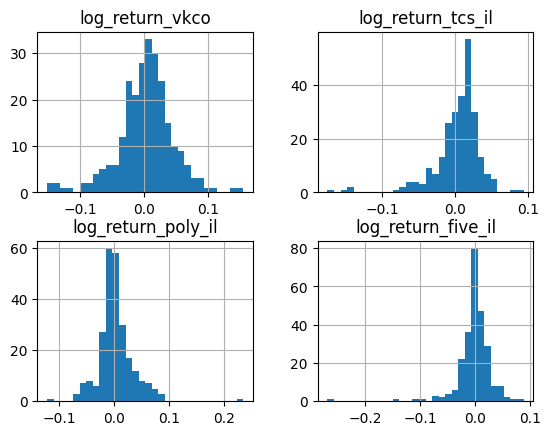

In [ ]:
df_meixner_distribution.hist(bins=30)

In [ ]:
df_meixner_distribution.to_csv('../data/df_meixner_distribution.csv')

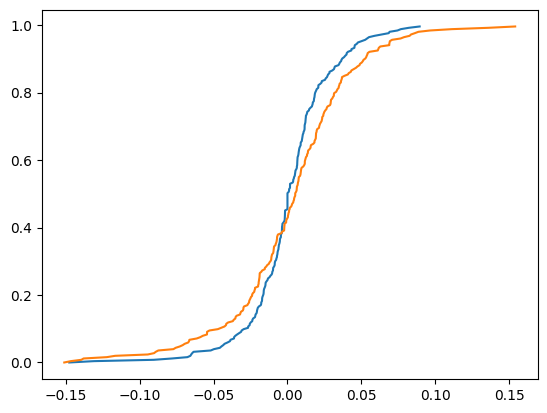

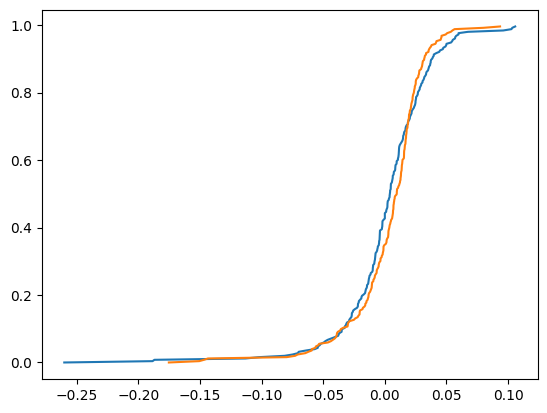

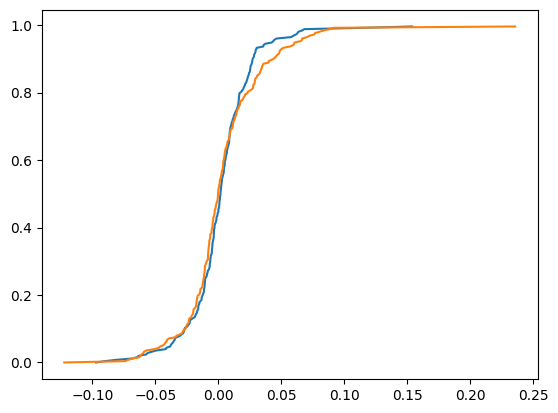

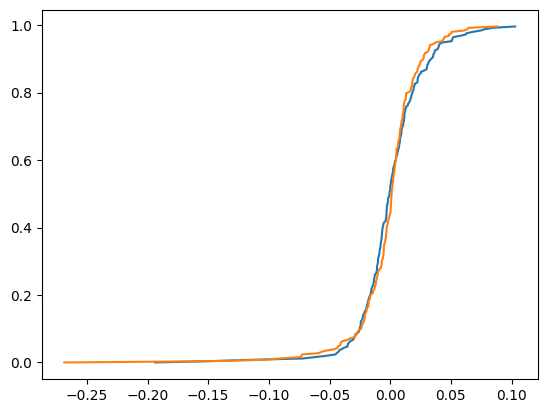

In [ ]:
for column in dataset.columns:
    a = plt.plot(dataset[column].sort_values(), [i / 253 for i in range(253)])
    plt.plot(df_meixner_distribution[column].sort_values(), [i / 253 for i in range(253)])
    plt.show()